In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.gradient.utils import dominant_set

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env

In [4]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 200 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

In [5]:
if parc_str == 'schaefer' or parc_str == 'glasser':
    exclude_str = 't1Exclude'
else:
    exclude_str = 'fsFinalExclude'

In [6]:
# output file prefix
outfile_prefix = parc_str+'_'+str(parc_scale)+'_'
outfile_prefix

'schaefer_200_'

In [7]:
# here, we focus just on the cortex
if parc_str == 'lausanne':
    num_parcels = np.sum(parcel_loc==1)
#     num_parcels = np.sum(parcel_loc!=2)
print(num_parcels)

200


### Setup directory variables

In [8]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [9]:
outputdir = os.path.join(os.environ['PIPELINEDIR'], '2_compute_gradient', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/2_compute_gradient/out


In [10]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


## Load data

In [11]:
# Load data
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out', exclude_str+'_df_gradients.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(926, 54)


In [12]:
df['ageAtScan1_Years'].mean()

15.76965442764579

In [13]:
df['ageAtScan1_Years'].std()

3.292211495195789

In [14]:
# Missing data file for this subject only for lausanne 250
if parc_str == 'lausanne' and parc_scale == 250:
    df.drop(labels = (131747, 8108), inplace=True)

In [15]:
num_subs = df.shape[0]; print(num_subs)
num_time = 120

print(num_parcels)
num_connections = num_parcels * (num_parcels - 1) / 2; print(num_connections)

926
200
19900.0


## Load in time series, compute FC

In [16]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [17]:
# fc stored as 3d matrix, subjects of 3rd dim
fc = np.zeros((num_parcels, num_parcels, num_subs))

for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = os.environ['RSTS_NAME_TMP'].replace("bblid", str(index[0]))
    file_name = file_name.replace("scanid", str(index[1]))
    full_path = glob.glob(os.path.join(os.environ['RSTSDIR'], file_name))
    if i == 0: print(full_path)
        
    if len(full_path) > 0:
        roi_ts = np.loadtxt(full_path[0])
        if parc_str == 'lausanne':
            roi_ts = roi_ts[:,parcel_loc == 1] # retain only the cortex
#             roi_ts = roi_ts[:,parcel_loc != 2] # retain only the cortex
        fc[:,:,i] = np.corrcoef(roi_ts, rowvar = False)
        # fisher r to z
        fc[:,:,i] = np.arctanh(fc[:,:,i])
        np.fill_diagonal(fc[:,:,i], 1)

        if np.any(np.isnan(fc[:,:,i])):
            subj_filt[i] = True

    elif len(full_path) == 0:
        print(file_name + ': NOT FOUND')
        subj_filt[i] = True
        fc[:,:,i] = np.full((num_parcels, num_parcels), np.nan)

['/Volumes/work_ssd/research_data/PNC/processedData/restbold/restbold_201607151621/81287/20100114x2738/net/Schaefer200PNC/81287_20100114x2738_Schaefer200PNC_ts.1D']


/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in arctanh


In [18]:
np.sum(subj_filt)

0

In [19]:
if any(subj_filt):
    df = df.loc[~subj_filt]
    fc = fc[:,:,~subj_filt]

### Generate participant gradients

In [20]:
# Generate template
pnc_conn_mat = np.nanmean(fc, axis = 2)
pnc_conn_mat[np.eye(num_parcels, dtype = bool)] = 0
# pnc_conn_mat = dominant_set(pnc_conn_mat, 0.10, as_sparse = False)

gm_template = GradientMaps(n_components = 5, approach='dm', kernel='normalized_angle', random_state = 0)
gm_template.fit(pnc_conn_mat)

if parc_str == 'schaefer' and parc_scale == 200:
    gradients = gm_template.gradients_ * -1
elif parc_str == 'glasser' and parc_scale == 360:
    gradients = gm_template.gradients_ * -1 
elif parc_str == 'lausanne' and parc_scale == 125 and num_parcels == 219:
    gradients = np.zeros(gm_template.gradients_.shape)
    gradients[:,0] = gm_template.gradients_[:,1]
    gradients[:,1] = gm_template.gradients_[:,0]
elif parc_str == 'lausanne' and parc_scale == 125 and num_parcels == 233:
    gradients = gm_template.gradients_ * -1
elif parc_str == 'lausanne' and parc_scale == 250:
    gradients = gm_template.gradients_ * -1
else:
    gradients = gm_template.gradients_

np.savetxt(os.path.join(outputdir,outfile_prefix+'pnc_grads_template.txt'),gradients)

# Plots

In [21]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)

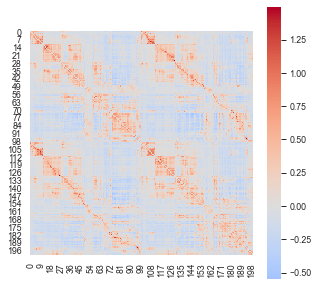

In [22]:
f, ax = plt.subplots(1, figsize=(5, 5))
sns.heatmap(pnc_conn_mat, cmap = 'coolwarm', center = 0, square = True)
f.savefig(outfile_prefix+'mean_fc.png', dpi = 300, bbox_inches = 'tight')

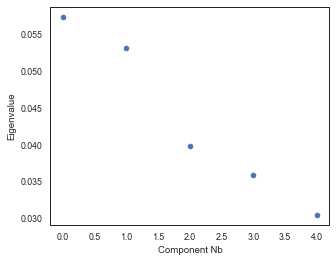

In [23]:
f, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm_template.lambdas_.size), gm_template.lambdas_)
ax.set_xlabel('Component Nb')
ax.set_ylabel('Eigenvalue')
f.savefig(outfile_prefix+'gradient_eigenvals.png', dpi = 300, bbox_inches = 'tight')

In [24]:
import matplotlib.image as mpimg
from brain_plot_func import brain_plot

Notebook initialized with png backend.


In [25]:
if parc_str == 'schaefer' or parc_str == 'glasser':
    subject_id = 'fsaverage'
elif parc_str == 'lausanne':
    subject_id = 'lausanne125'

surf = 'inflated'

In [26]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Brain plots nispat

In [27]:
for i in range(0,1):
    for hemi in ('lh', 'rh'):
        # Plots of univariate pheno correlation
        fig_str = hemi + '_gradient_' + str(i)

        if parc_str == 'schaefer':
            parc_file = os.path.join(os.environ['PROJDIR'],'figs_support','Parcellations','FreeSurfer5.3','fsaverage','label',
                                     hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')
        elif parc_str == 'glasser':
            parc_file = os.path.join(os.environ['PROJDIR'],'figs_support','Parcellations','FreeSurfer5.3','fsaverage','label',
                                     hemi + '.HCP-MMP1.annot')    
        elif parc_str == 'lausanne':
            parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
            
        if parc_str == 'lausanne' and parc_scale == 125 and num_parcels == 219:
            brain_plot(gradients[:,i], parcel_names[parcel_loc==1], parc_file, fig_str, subject_id = subject_id, surf = surf, hemi = hemi, color = 'viridis', showcolorbar = False)
        elif parc_str == 'lausanne' and parc_scale == 125 and num_parcels == 233:
            brain_plot(gradients[:,i], parcel_names[parcel_loc!=2], parc_file, fig_str, subject_id = subject_id, surf = surf, hemi = hemi, color = 'viridis', showcolorbar = False)
        else:
            brain_plot(gradients[:,i], parcel_names, parc_file, fig_str, subject_id = subject_id, surf = surf, hemi = hemi, color = 'viridis', showcolorbar = False)

In [28]:
%matplotlib inline

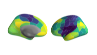

In [29]:
for i in range(0,1):
    f, axes = plt.subplots(1,2)
    f.set_figwidth(1.5)
    f.set_figheight(0.75)
    plt.subplots_adjust(wspace=0, hspace=0)

    # column 0:
    fig_str = 'lh_gradient_' + str(i) + '.png'
    try:
    #     axes[0,0].set_title('Thickness (left)')
        image = mpimg.imread('med_' + fig_str); axes[0].imshow(image); axes[0].axis('off')
    except FileNotFoundError: axes[0].axis('off')
    try:
        image = mpimg.imread('lat_' + fig_str); axes[1].imshow(image); axes[1].axis('off')
    except FileNotFoundError: axes[1].axis('off')

    plt.show()
    f.savefig(outfile_prefix+'gradient_' + str(i) + '.svg', dpi = 600, bbox_inches = 'tight', pad_inches = 0)

In [30]:
# clean up
fileList = glob.glob(os.path.join(figdir,'lat_*.png'), recursive=True)
print(fileList)
for filePath in fileList: os.remove(filePath)

['/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs/lat_lh_gradient_0.png', '/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs/lat_rh_gradient_0.png']


In [31]:
fileList = glob.glob(os.path.join(figdir,'med_*.png'), recursive=True)
print(fileList)
for filePath in fileList: os.remove(filePath)

['/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs/med_lh_gradient_0.png', '/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs/med_rh_gradient_0.png']
